In [41]:
import pandas as pd

df = pd.read_csv("crm_opportunities.csv")
df['Signup_Date'] = pd.to_datetime(df['Signup_Date'], errors='coerce')
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   User_ID         500 non-null    object        
 1   Signup_Date     500 non-null    datetime64[ns]
 2   Bet_Amount      500 non-null    float64       
 3   Region          500 non-null    object        
 4   Account_Status  500 non-null    object        
 5   Login_Count     500 non-null    int64         
 6   Customer_Type   500 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 27.5+ KB


In [43]:

column_info = {
    "User_ID": ["object", "Her kullanıcıya ait benzersiz tanımlayıcı (ID)."],
    "Signup_Date": ["object", "Kullanıcının sisteme kayıt olduğu tarih."],
    "Bet_Amount": ["float64", "Kullanıcının toplam harcama/bahis miktarı."],
    "Region": ["object", "Kullanıcının coğrafi bölgesi."],
    "Account_Status": ["object", "Hesabın güncel durumu (aktif, askıya alınmış vb)."],
    "Login_Count": ["int64", "Kullanıcının sisteme giriş sayısı."],
    "Customer_Type": ["object", "Müşteri sınıfı: yeni, düzenli, VIP gibi."]
}


summary_df = pd.DataFrame.from_dict(column_info, orient='index',
                                    columns=["Veri Tipi", "Açıklama"])


summary_df.index.name = "Sütun Adı"
summary_df.reset_index(inplace=True)


print(summary_df)

        Sütun Adı Veri Tipi                                           Açıklama
0         User_ID    object    Her kullanıcıya ait benzersiz tanımlayıcı (ID).
1     Signup_Date    object           Kullanıcının sisteme kayıt olduğu tarih.
2      Bet_Amount   float64         Kullanıcının toplam harcama/bahis miktarı.
3          Region    object                      Kullanıcının coğrafi bölgesi.
4  Account_Status    object  Hesabın güncel durumu (aktif, askıya alınmış vb).
5     Login_Count     int64                 Kullanıcının sisteme giriş sayısı.
6   Customer_Type    object           Müşteri sınıfı: yeni, düzenli, VIP gibi.


Bu veri seti, kullanıcıların platforma kayıt tarihleri, coğrafi bölgeleri, hesap durumları, harcama miktarları (Bet_Amount), giriş sayıları ve müşteri tipleri gibi bilgileri içerir. Amaç, kullanıcı davranışlarını analiz ederek müşteri segmentasyonu yapmak, yüksek değerli müşterileri belirlemek, kullanıcı bağlılığını ölçmek ve potansiyel churn (kayıp) risklerini öngörmektir.

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Bet_Amount,500.0,2509.7045,1455.018248,7.03,1239.195,2521.555,3762.5725,4996.42
Login_Count,500.0,102.4560,57.653898,1.00,51.750,102.000,153.0000,200.00


#### Coefficient of Variation (CV)

In [45]:
def calculate_cv(series):
    return (series.std() / series.mean()) * 100


excluded_columns = ['User_ID', 'Signup_Date', 'Region', 'Account_Status', 'Customer_Type']
numerical_df = df.drop(columns=excluded_columns, errors='ignore').select_dtypes(include=['float64', 'int64'])


cv_values = {col: calculate_cv(numerical_df[col]) for col in numerical_df.columns}


for col, cv in cv_values.items():
    print(f"Coefficient of Variation for {col}: %{cv:.2f}")
    if cv > 25:
        print(f"  -> {col} verisi geniş bir dağılıma sahip, yayılma fazla!")
    else:
        print(f"  -> {col} verisi dar bir dağılıma sahip.")


Coefficient of Variation for Bet_Amount: %57.98
  -> Bet_Amount verisi geniş bir dağılıma sahip, yayılma fazla!
Coefficient of Variation for Login_Count: %56.27
  -> Login_Count verisi geniş bir dağılıma sahip, yayılma fazla!


In [47]:
df.select_dtypes(include=['object', 'category']).describe().T


,count,unique,top,freq
User_ID,500,500,6ffd5bf1,1
Region,500,6,South America,96
Account_Status,500,3,Fraudulent,171
Customer_Type,500,3,New,180


In [51]:
df.isnull().sum()


User_ID           0
Signup_Date       0
Bet_Amount        0
Region            0
Account_Status    0
Login_Count       0
Customer_Type     0
dtype: int64

In [53]:
for col in ['Region', 'Account_Status', 'Customer_Type']:
    print(f"{col} unique values:\n", df[col].value_counts(), "\n")


Region unique values:
 Region
South America    96
Asia             88
Africa           85
Australia        79
North America    78
Europe           74
Name: count, dtype: int64 

Account_Status unique values:
 Account_Status
Fraudulent    171
Suspended     170
Active        159
Name: count, dtype: int64 

Customer_Type unique values:
 Customer_Type
New           180
Regular       176
High-value    144
Name: count, dtype: int64 



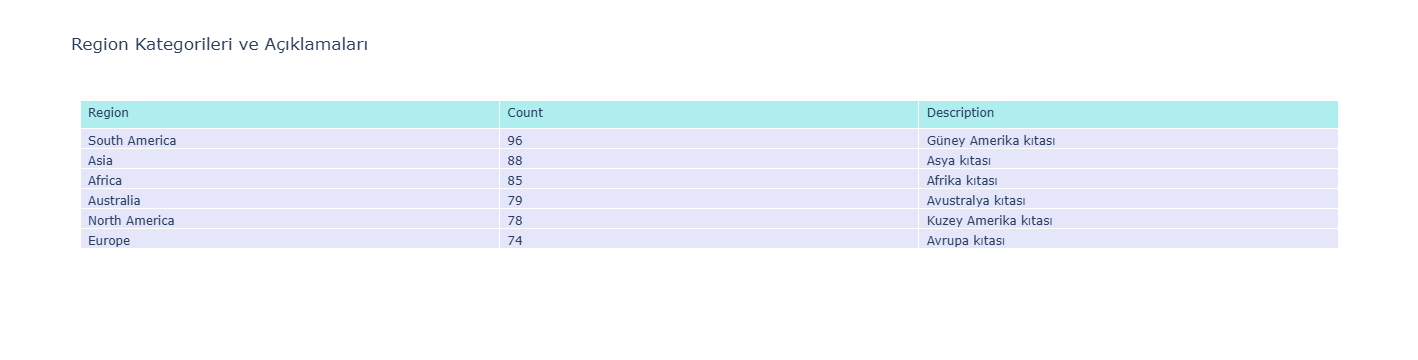

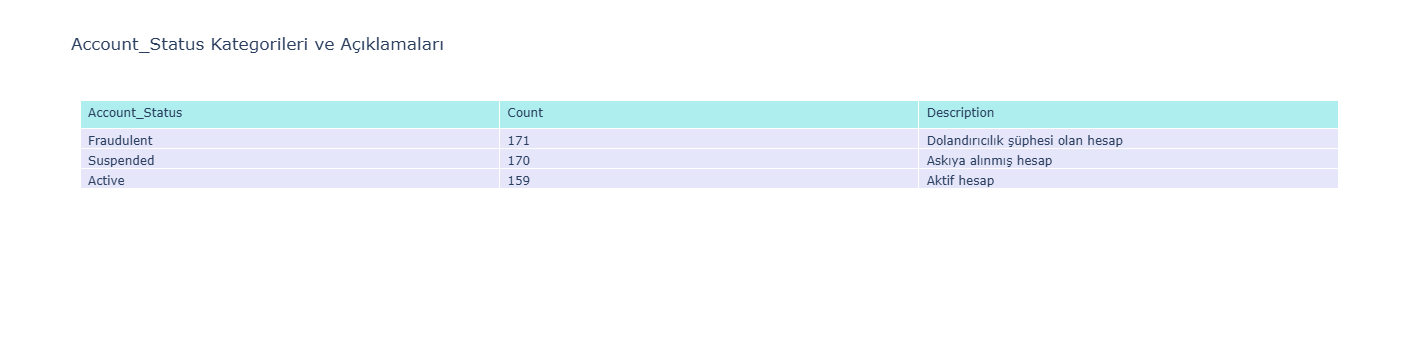

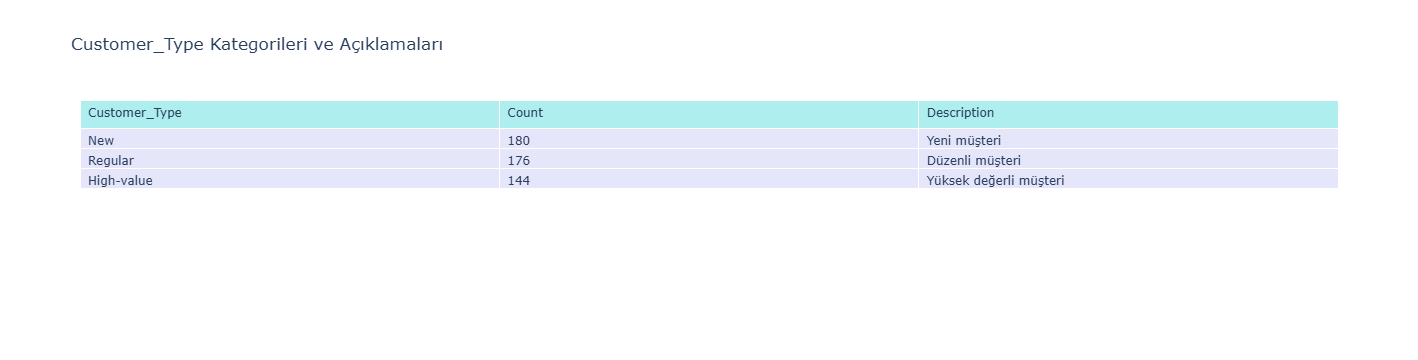

In [133]:
import pandas as pd
import plotly.graph_objects as go


category_descriptions = {
    'Region': {
        'South America': 'Güney Amerika kıtası',
        'Asia': 'Asya kıtası',
        'Africa': 'Afrika kıtası',
        'Australia': 'Avustralya kıtası',
        'North America': 'Kuzey Amerika kıtası',
        'Europe': 'Avrupa kıtası',
    },
    'Account_Status': {
        'Fraudulent': 'Dolandırıcılık şüphesi olan hesap',
        'Suspended': 'Askıya alınmış hesap',
        'Active': 'Aktif hesap',
    },
    'Customer_Type': {
        'New': 'Yeni müşteri',
        'Regular': 'Düzenli müşteri',
        'High-value': 'Yüksek değerli müşteri',
    }
}

def plot_category_table(df, col, desc_dict):
    counts = df[col].value_counts()
    desc = pd.Series(desc_dict)
    summary = pd.DataFrame({'Category': counts.index, 'Count': counts.values})
    summary['Description'] = summary['Category'].map(desc)
    
    fig = go.Figure(data=[go.Table(
        header=dict(values=[col, 'Count', 'Description'],
                    fill_color='paleturquoise', align='left'),
        cells=dict(values=[summary['Category'], summary['Count'], summary['Description']],
                   fill_color='lavender', align='left'))
    ])
    fig.update_layout(title_text=f"{col} Kategorileri ve Açıklamaları", height=350)
    fig.show()


for col in ['Region', 'Account_Status', 'Customer_Type']:
    plot_category_table(df, col, category_descriptions[col])


<Axes: title={'center': 'Müşteri Türleri Dağılımı'}, xlabel='Customer_Type'>

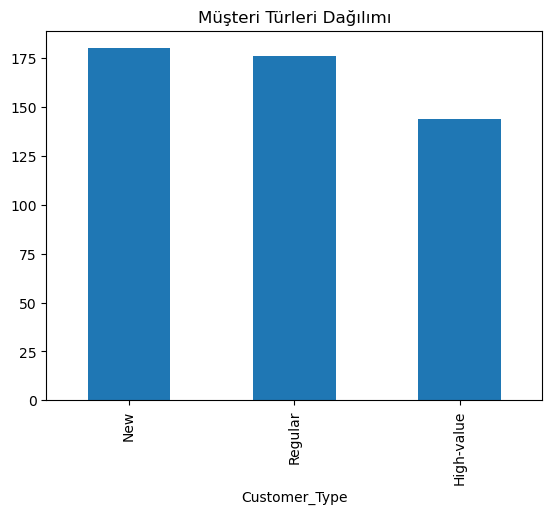

In [55]:
df['Customer_Type'].value_counts().plot(kind='bar', title='Müşteri Türleri Dağılımı')


<Axes: xlabel='Region'>

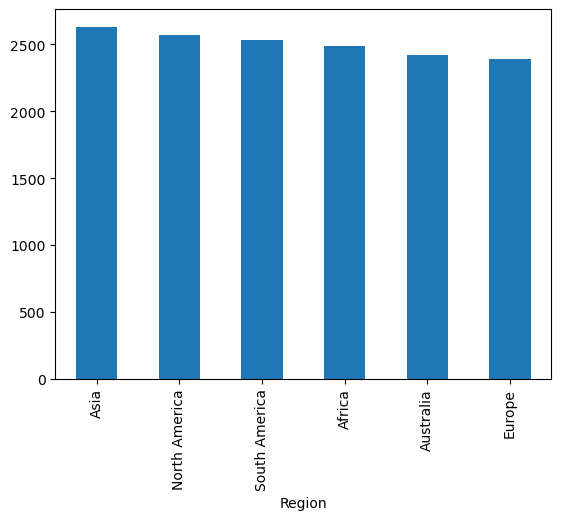

In [57]:
df.groupby('Region')['Bet_Amount'].mean().sort_values(ascending=False).plot(kind='bar')


### RFM Analizi (Recency-Frequency-Monetary)

In [76]:
snapshot_date = df['Signup_Date'].max() + pd.Timedelta(days=1)

rfm = df.copy()
rfm['Recency'] = (snapshot_date - rfm['Signup_Date']).dt.days
rfm['Frequency'] = rfm['Login_Count']
rfm['Monetary'] = rfm['Bet_Amount']
rfm = rfm[['User_ID', 'Recency', 'Frequency', 'Monetary']]
rfm.set_index('User_ID', inplace=True)
rfm.head(10)


,Recency,Frequency,Monetary
User_ID,,,
6ffd5bf1,712,174,3198.94
78e0e5f3,248,174,129.93
f97c8068,685,152,1378.77
8c0d52dd,288,125,1119.94
be52ea12,306,135,3683.67
a56af395,94,171,3385.11
f28ca36e,531,79,4461.44
c6156808,139,12,439.26
455dba05,333,57,2112.50


In [78]:

# Skorlar int olsun
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Segment fonksiyonunu geliştir
def segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'VIP'
    elif row['R_Score'] >= 4:
        return 'Yeni-Aktif'
    elif row['F_Score'] >= 4:
        return 'Sadık'
    elif row['M_Score'] >= 4:
        return 'Değerli'
    elif row['R_Score'] == 1:
        return 'Riskli'
    else:
        return 'Orta Seviye'

rfm['Segment'] = rfm.apply(segment, axis=1)
print(rfm['Segment'].value_counts())


Segment
Yeni-Aktif     172
Sadık          108
Değerli         82
Orta Seviye     74
Riskli          33
VIP             31
Name: count, dtype: int64


### Veri Görselleştirme

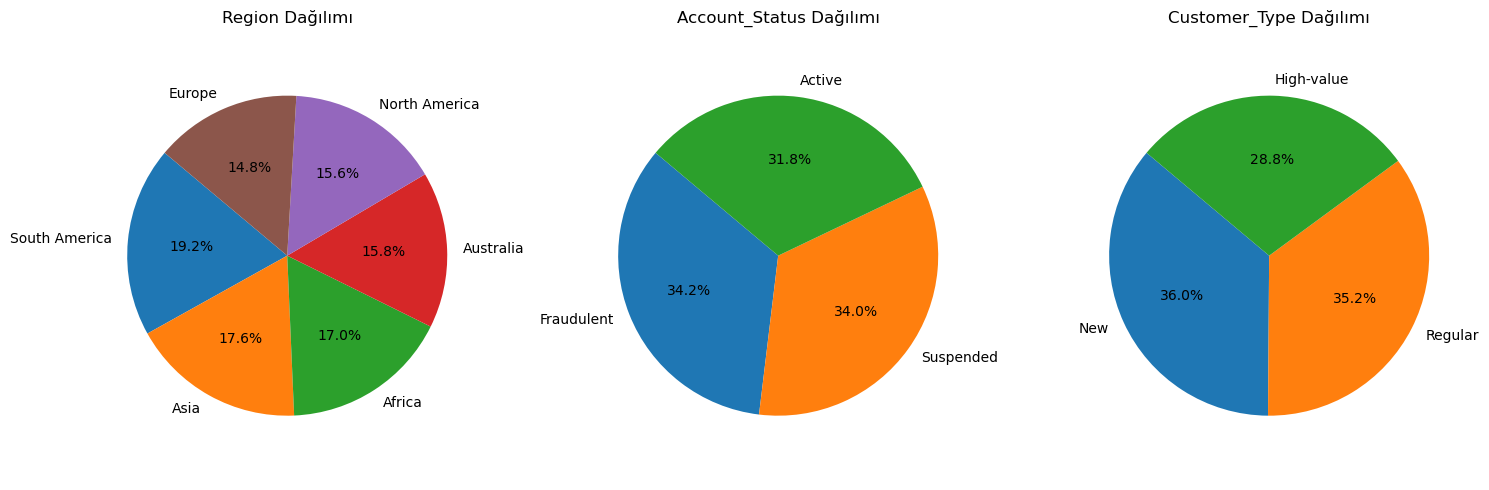

In [109]:
import matplotlib.pyplot as plt


categorical_cols = ['Region', 'Account_Status', 'Customer_Type']

plt.figure(figsize=(15, 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    data = df[col].value_counts()
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'{col} Dağılımı')
    plt.axis('equal') 

plt.tight_layout()
plt.show()


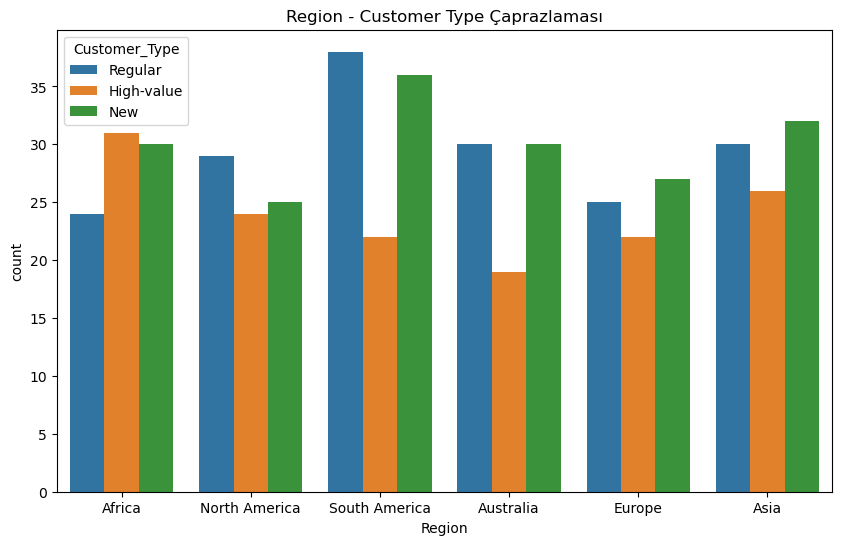

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Region', hue='Customer_Type')
plt.title('Region - Customer Type Çaprazlaması')
plt.show()


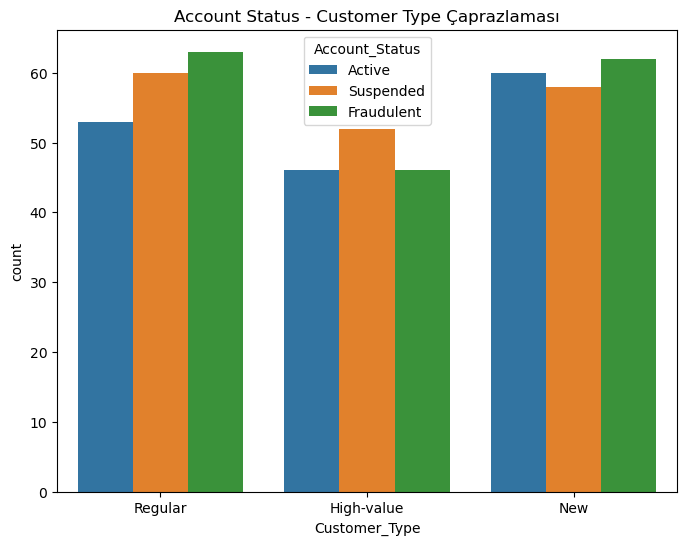

In [125]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Customer_Type', hue='Account_Status')
plt.title('Account Status - Customer Type Çaprazlaması')
plt.show()


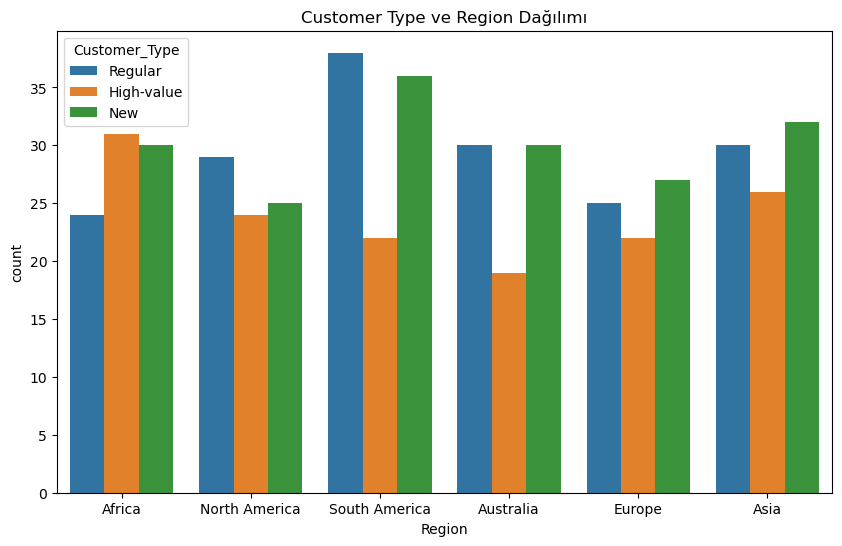

In [127]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Region', hue='Customer_Type')
plt.title('Customer Type ve Region Dağılımı')
plt.show()



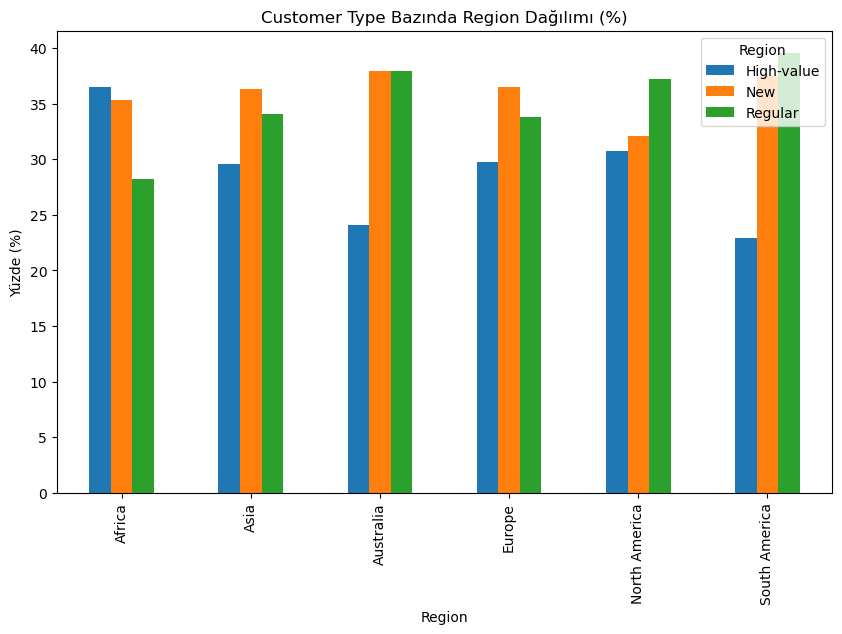

In [135]:

pivot = pd.crosstab(df['Region'], df['Customer_Type'], normalize='index') * 100

pivot.plot(kind='bar', stacked=False, figsize=(10,6))
plt.ylabel('Yüzde (%)')
plt.title('Customer Type Bazında Region Dağılımı (%)')
plt.legend(title='Region')
plt.show()



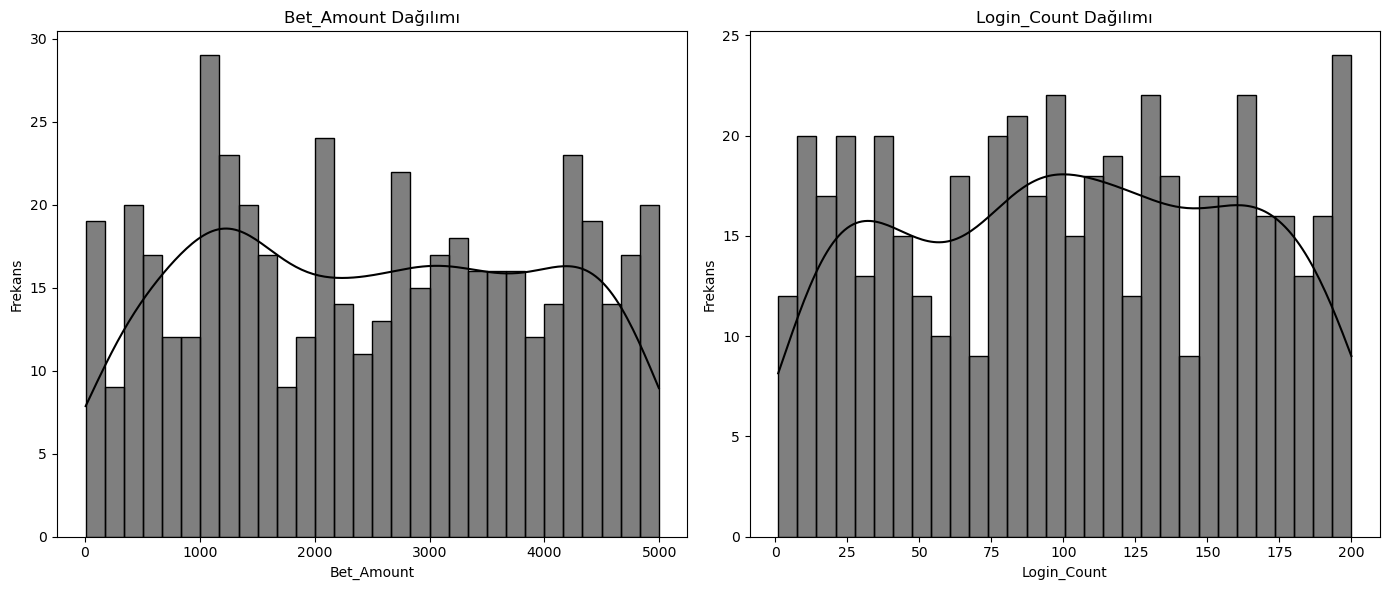

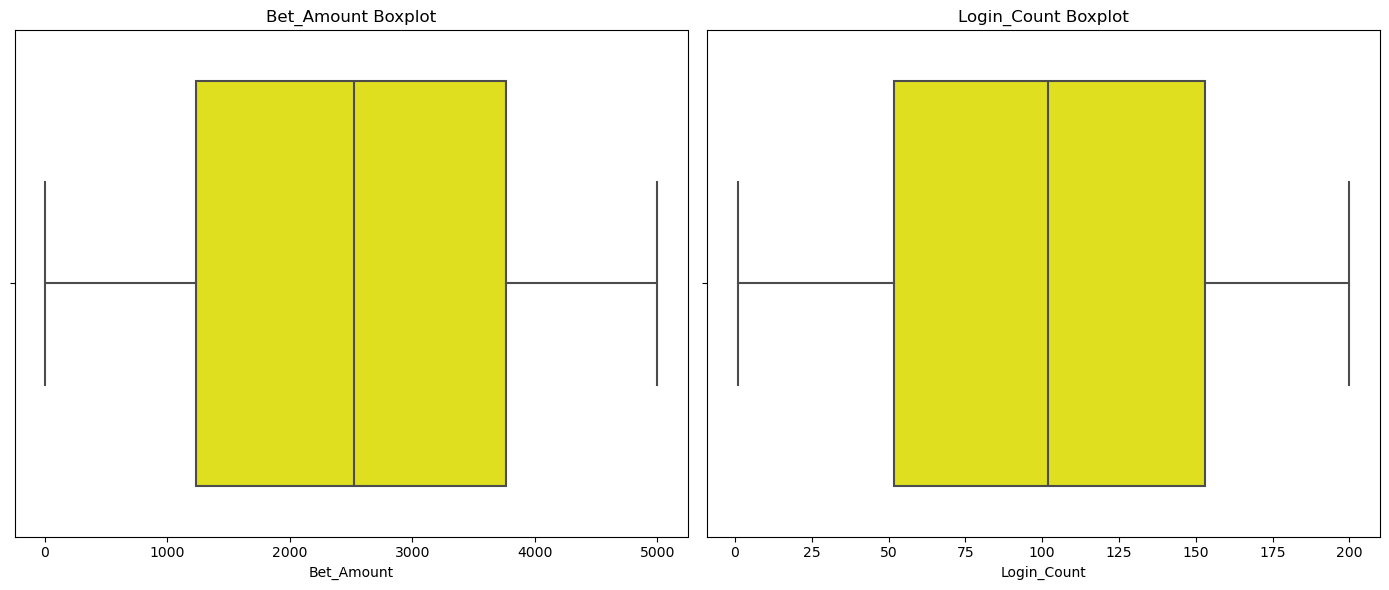

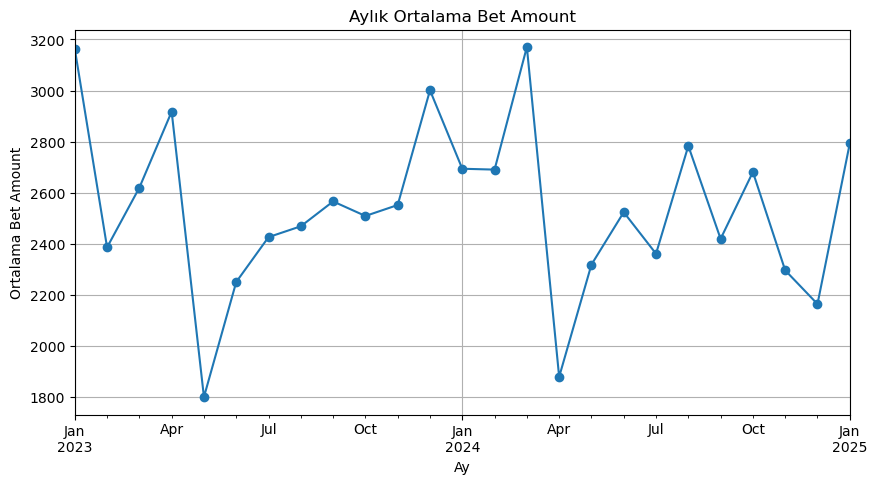

In [151]:

num_cols = ['Bet_Amount', 'Login_Count']

plt.figure(figsize=(14, 6))


for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], kde=True, bins=30, color='black')
    plt.title(f'{col} Dağılımı')
    plt.xlabel(col)
    plt.ylabel('Frekans')

plt.tight_layout()
plt.show()



plt.figure(figsize=(14, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[col], color='yellow')
    plt.title(f'{col} Boxplot')
    plt.xlabel(col)

plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 5))
df.groupby(df['Signup_Date'].dt.to_period('M'))['Bet_Amount'].mean().plot(marker='o')
plt.title('Aylık Ortalama Bet Amount')
plt.xlabel('Ay')
plt.ylabel('Ortalama Bet Amount')
plt.grid(True)
plt.show()


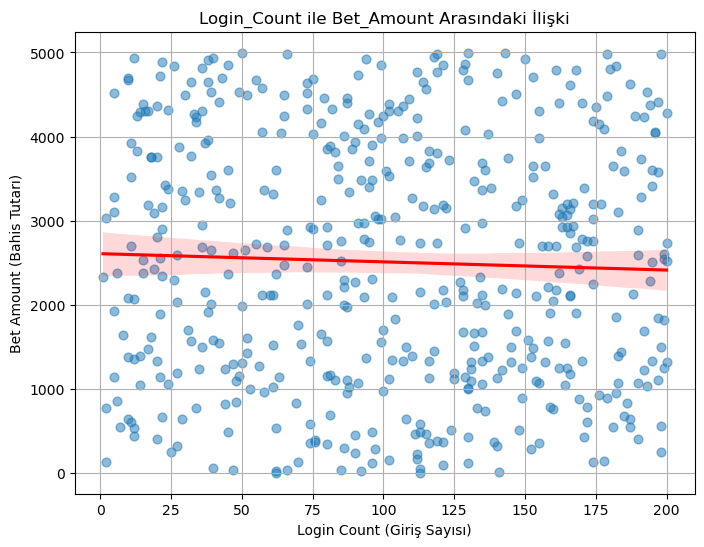

In [153]:


plt.figure(figsize=(8,6))
sns.regplot(x='Login_Count', y='Bet_Amount', data=df, scatter_kws={'alpha':0.5, 's':40}, line_kws={'color':'red'})
plt.title('Login_Count ile Bet_Amount Arasındaki İlişki')
plt.xlabel('Login Count (Giriş Sayısı)')
plt.ylabel('Bet Amount (Bahis Tutarı)')
plt.grid(True)
plt.show()


Noktalar her yerde dağılmış, yani Login_Count arttıkça Bet_Amount net bir şekilde artmıyor ya da azalmıyor.

Yoğunluk belirli bir aralıkta değil, sağa sola yayılmış, yani kullanıcılar farklı login sayılarına ve farklı bahis miktarlarına sahip.

Çizgi neredeyse düz ama hafif negatif eğim var.

Bu, login sayısı arttıkça ortalama bahis miktarının biraz azaldığı anlamına gelebilir ama çok zayıf bir ilişki.

Yani, sık giren kullanıcılar biraz daha küçük bahis yapıyor olabilir.

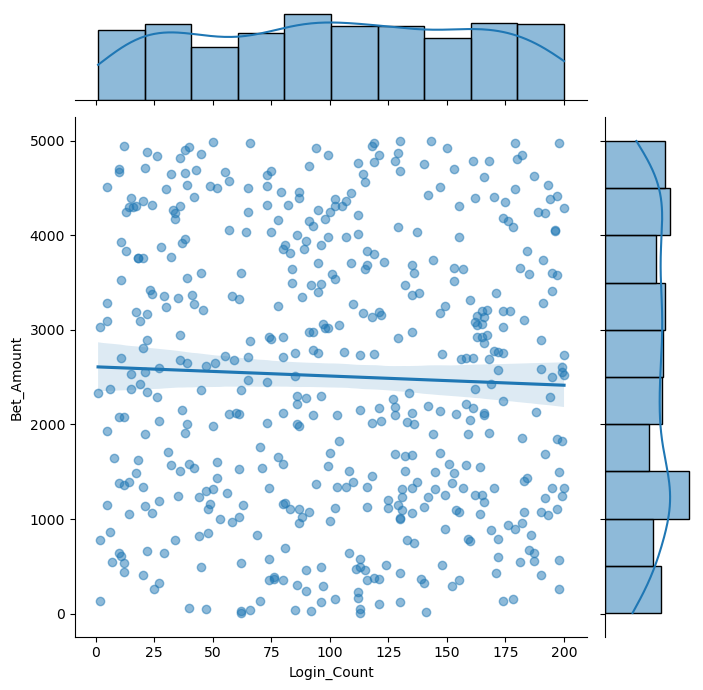

In [155]:
sns.jointplot(x='Login_Count', y='Bet_Amount', data=df, kind='reg', height=7, scatter_kws={'alpha':0.5})
plt.show()


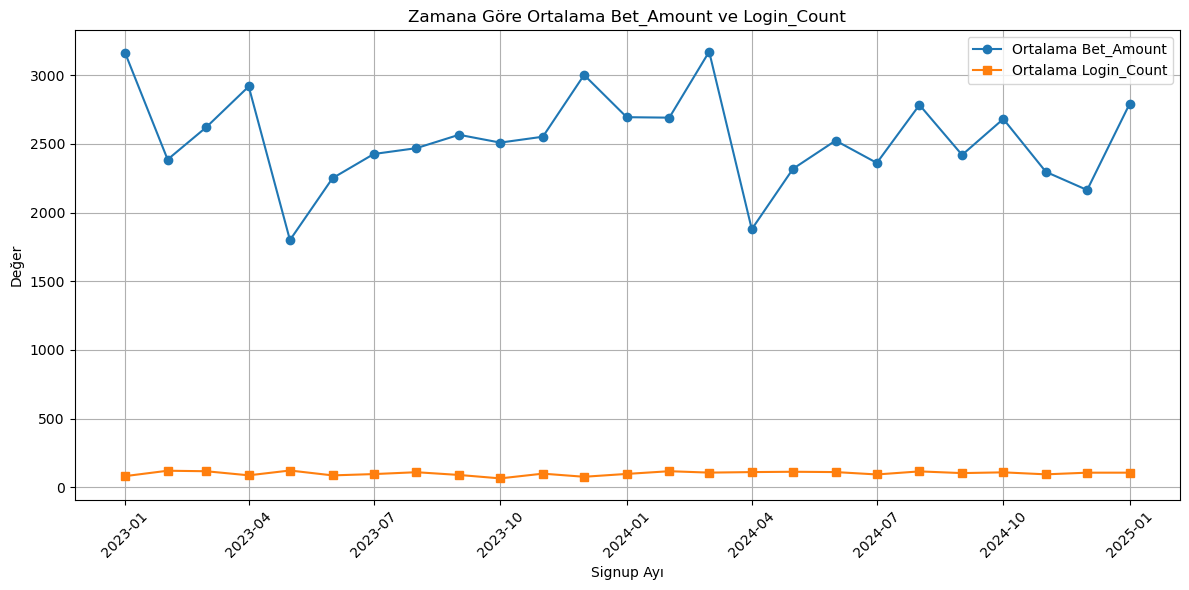

In [164]:


df['Signup_Month'] = df['Signup_Date'].dt.to_period('M').dt.to_timestamp()


monthly_avg = df.groupby('Signup_Month')[['Bet_Amount', 'Login_Count']].mean()


plt.figure(figsize=(12,6))
plt.plot(monthly_avg.index, monthly_avg['Bet_Amount'], label='Ortalama Bet_Amount', marker='o')
plt.plot(monthly_avg.index, monthly_avg['Login_Count'], label='Ortalama Login_Count', marker='s')
plt.title('Zamana Göre Ortalama Bet_Amount ve Login_Count')
plt.xlabel('Signup Ayı')
plt.ylabel('Değer')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


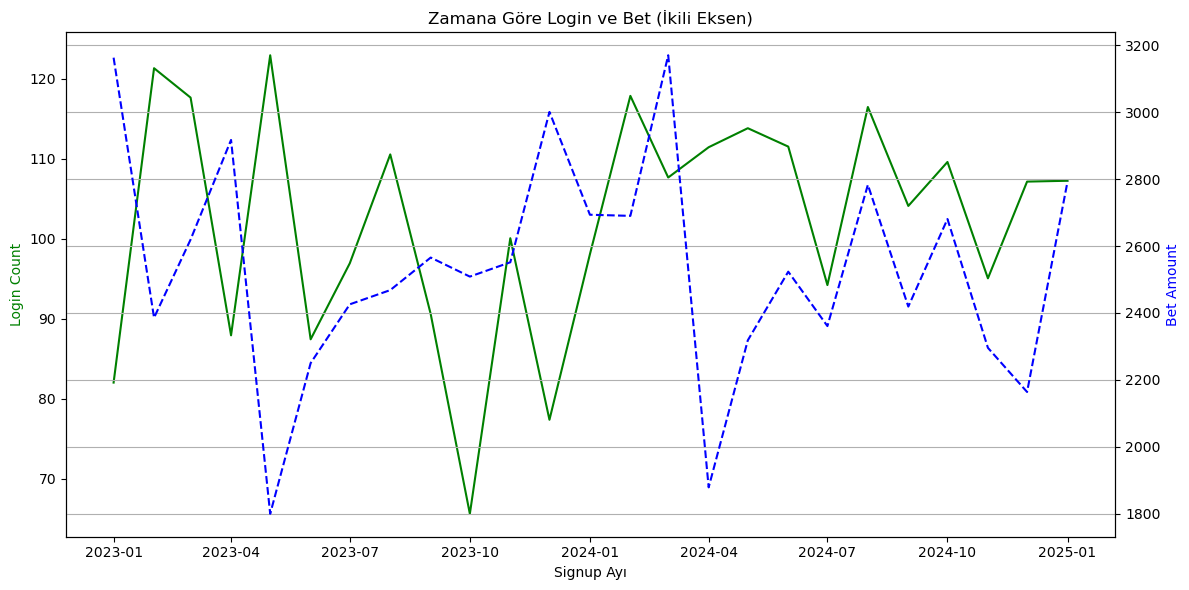

In [170]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.plot(monthly_avg.index, monthly_avg['Login_Count'], 'g-', label='Login Count')
ax2.plot(monthly_avg.index, monthly_avg['Bet_Amount'], 'b--', label='Bet Amount')

ax1.set_xlabel('Signup Ayı')
ax1.set_ylabel('Login Count', color='g')
ax2.set_ylabel('Bet Amount', color='b')

plt.title('Zamana Göre Login ve Bet (İkili Eksen)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


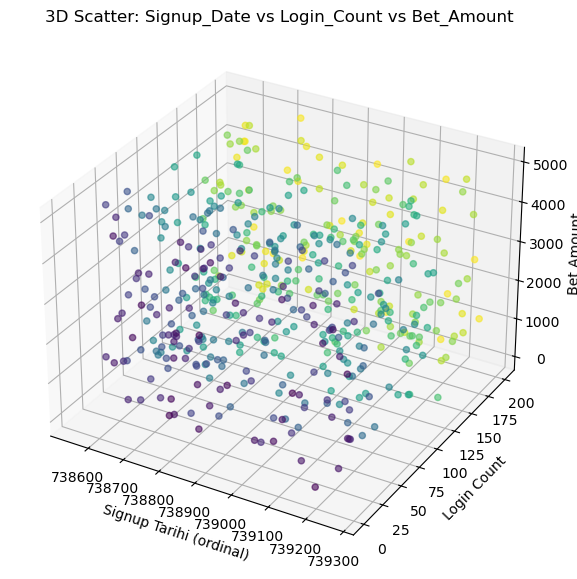

In [166]:
from mpl_toolkits.mplot3d import Axes3D


df['Signup_Ordinal'] = df['Signup_Date'].map(pd.Timestamp.toordinal)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['Signup_Ordinal'], df['Login_Count'], df['Bet_Amount'],
           c=df['Login_Count'], cmap='viridis', alpha=0.6)

ax.set_xlabel('Signup Tarihi (ordinal)')
ax.set_ylabel('Login Count')
ax.set_zlabel('Bet Amount')
plt.title('3D Scatter: Signup_Date vs Login_Count vs Bet_Amount')
plt.show()


Veri Seti Genel Özeti
Toplam kayıt: 500 kullanıcı

Özellikler:

User_ID: Benzersiz kullanıcı kimliği (object)

Signup_Date: Kayıt tarihi (datetime)

Bet_Amount: Toplam bahis/harcama miktarı (float)

Region: Coğrafi bölge (6 farklı kıta/ülke grubu)

Account_Status: Hesap durumu (Aktif, Askıya alınmış, Sahte/Fraudulent)

Login_Count: Sisteme giriş sayısı (int)

Customer_Type: Müşteri tipi (Yeni, Düzenli, Yüksek değerli)

Veri Kalitesi ve Dağılımlar
Eksik veri yok, tüm sütunlarda 500/500 kayıt mevcut.

Bet_Amount ve Login_Count değişkenlerinin yayılımı yüksek, yani kullanıcılar arasında çok farklı harcama ve giriş sayıları var (Coefficient of Variation %57+).

Bölgesel dağılım dengeli sayılır, en fazla kullanıcı Güney Amerika’da (96), en az Avrupa’da (74).

Hesap durumu olarak Fraudulent (Sahte) ve Suspended (Askıya alınmış) hesapların sayısı aktiflere yakın, bu kritik bir uyarı olabilir.

Müşteri tipi açısından yeni ve düzenli kullanıcılar neredeyse eşit, yüksek değerli kullanıcılar biraz daha az.

Müşteri Segmentasyonu ve RFM
RFM analiziyle (Recency, Frequency, Monetary) kullanıcı davranışları detaylı analiz edilmiş.

En sık bahis yapan ve en çok harcama yapan kullanıcılar tespit edilmiş (ör. bazı kullanıcılar 3000+ para harcarken bazıları 100 civarında).

Segment dağılımı: Yeni-Aktif, Sadık, Değerli, Orta Seviye, Riskli, VIP olarak çeşitlendirilmiş.

Riskli ve VIP kullanıcılar nispeten az sayıda (33 ve 31 kişi).

 İlişki İncelemesi
Login_Count ile Bet_Amount arasında net bir pozitif ilişki yok.

Grafiklerde login sayısı arttıkça bahis miktarının sabit ya da hafifçe azaldığı gözlenmiş.

Bu durum, sık giriş yapanların ortalama daha küçük bahisler yaptığını gösterebilir; belki düşük bütçeli ama sık oynayan kullanıcılar mevcut.

Öneriler & İş Yorumları
Fraudulent ve Suspended hesaplar yüksek, bunlar için detaylı risk yönetimi ve doğrulama sistemleri geliştirilmeli.

Müşteri segmentlerine göre özelleştirilmiş kampanyalar yapılabilir:

Yeni kullanıcıları düzenli müşteriye dönüştürmek için destekler

Sadık ve VIP müşterilere özel teklifler

Riskli segment için yeniden kazanma stratejileri

Login_Count ve Bet_Amount ilişkisi zayıf olduğundan, kullanıcı bağlılığı sadece giriş sayısına değil başka parametrelere (örneğin müşteri memnuniyeti, kullanıcı tipi) bakılarak da ölçülmeli.

Bölgesel bazda kullanıcı davranışları karşılaştırılıp, lokal kampanyalar geliştirilebilir.